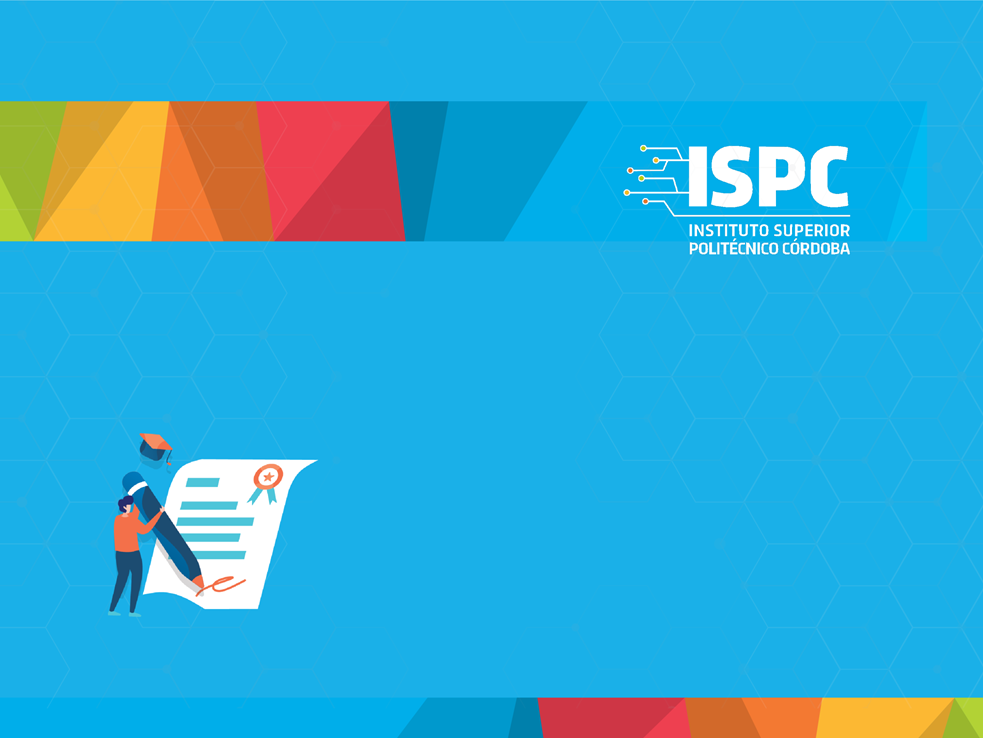

<a href="https://colab.research.google.com/github/joanby/python-ml-course/blob/master/notebooks/T10%20-%201%20-%20Analisis%20de%20Componentes%20Principales-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consignas:
# Analizar y resolver
# Subir a repositorio de Github, con al menos un pull request, y devolver el link

1- Generar un set de datos, con al menos 4 predictores

2- Dado el siguiente código indicar que tipo de problema instanta resolver. 

3- Evaluar los resultados.

4- Agregar otro algoritmo para resolver sobre el mismo set de datos.





In [46]:
#pip install pydataset

In [47]:
#pip install tensorflow

In [120]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime

# Gráficos
# ==============================================================================
import seaborn as sns
# Apply the default theme
sns.set_theme()

# Preprocesado y modelado
# ==============================================================================
from sklearn import datasets
from pydataset import data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import statsmodels.api as sm

import tensorflow as tf

# Configuración matplotlib
# ==============================================================================
from matplotlib import pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.simplefilter("ignore")
    
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Regresión lineal

# Para generar los datos usaremos las funciones provistas en sklearn

sklearn.datasets: Datasets


In [121]:
# Datos

diabetes_data = datasets.load_diabetes()
datos = pd.DataFrame(diabetes_data.data,columns=diabetes_data.feature_names)
datos['target'] = pd.Series(diabetes_data.target)
datos.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [122]:
datos.shape

(442, 11)

In [123]:
datos.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

In [124]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [125]:
# Correlación entre columnas numéricas

X = datos.drop(columns = 'target')
y = datos['target']

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = X.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
54,s2,s1,0.896663,0.896663
45,s1,s2,0.896663,0.896663
67,s3,s4,-0.738493,0.738493
76,s4,s3,-0.738493,0.738493
57,s2,s4,0.659817,0.659817
75,s4,s2,0.659817,0.659817
78,s4,s5,0.617857,0.617857
87,s5,s4,0.617857,0.617857
74,s4,s1,0.542207,0.542207
47,s1,s4,0.542207,0.542207


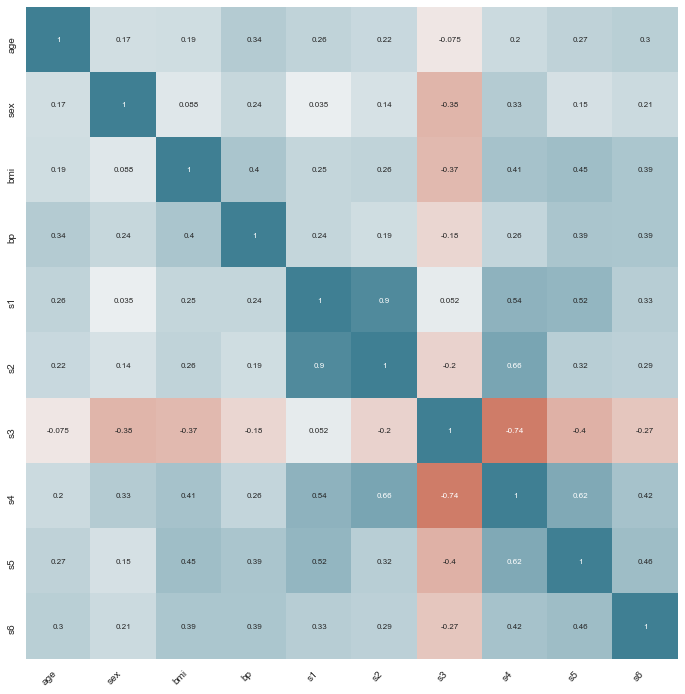

In [126]:
# Heatmap matriz de correlaciones

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

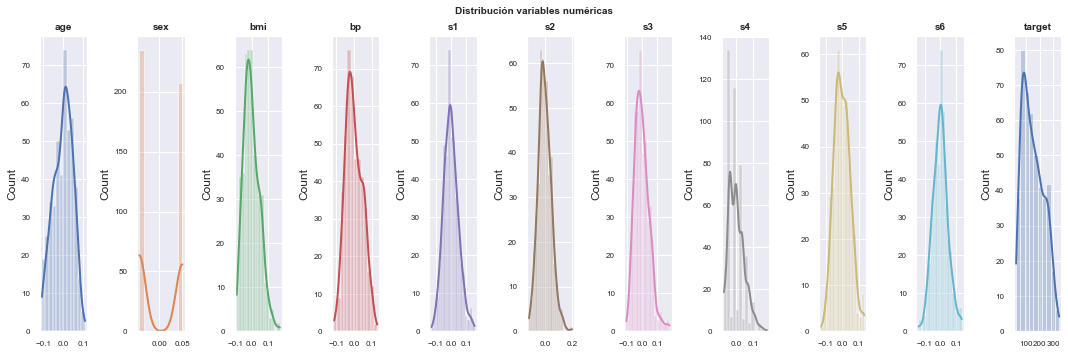

In [127]:
# Gráfico de distribución para cada variable numérica

fig, axes = plt.subplots(nrows=1, ncols=11, figsize=(15, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [128]:
datos.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

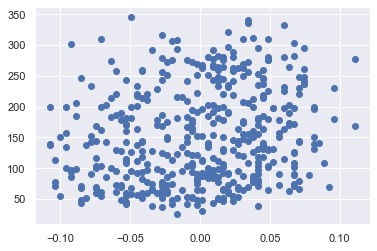

In [129]:
plt.scatter(datos['age'],datos['target'])

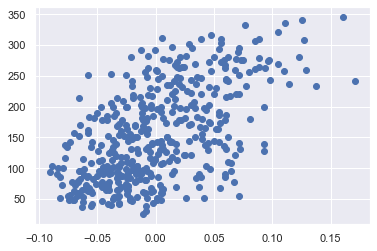

In [130]:
plt.scatter(datos['bmi'],datos['target'])

In [131]:
# FUNCION DE DIAGNOSTICOS DE RESIDUOS y GRAFICOS
def diagnostic_garbages(y_train, prediccion_train,residuos_train ):
  ''' 
  Se reciben los siguientes parametros
  y_train = vector de salida de entrenamiento
  prediccion_train =  resultado de diagnostico de errores
  residuos_train = resultado de diagnostico de errores
  '''
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

  axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                  'k--', color = 'black', lw=2)
  axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
  axes[0, 0].set_xlabel('Real')
  axes[0, 0].set_ylabel('Predicción')
  axes[0, 0].tick_params(labelsize = 7)

  axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                    edgecolors=(0, 0, 0), alpha = 0.4)
  axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
  axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
  axes[0, 1].set_xlabel('id')
  axes[0, 1].set_ylabel('Residuo')
  axes[0, 1].tick_params(labelsize = 7)

  sns.histplot(
      data    = residuos_train,
      stat    = "density",
      kde     = True,
      line_kws= {'linewidth': 1},
      color   = "firebrick",
      alpha   = 0.3,
      ax      = axes[1, 0]
  )

  axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                      fontweight = "bold")
  axes[1, 0].set_xlabel("Residuo")
  axes[1, 0].tick_params(labelsize = 7)


  sm.qqplot(
      residuos_train,
      fit   = True,
      line  = 'q',
      ax    = axes[1, 1], 
      color = 'firebrick',
      alpha = 0.4,
      lw    = 2
  )
  axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
  axes[1, 1].tick_params(labelsize = 7)

  axes[2, 0].scatter(prediccion_train, residuos_train,
                    edgecolors=(0, 0, 0), alpha = 0.4)
  axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
  axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
  axes[2, 0].set_xlabel('Predicción')
  axes[2, 0].set_ylabel('Residuo')
  axes[2, 0].tick_params(labelsize = 7)

  # Se eliminan los axes vacíos
  fig.delaxes(axes[2,1])

  fig.tight_layout()
  plt.subplots_adjust(top=0.9)
  fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     29.63
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           9.78e-39
Time:                        11:03:30   Log-Likelihood:                -1602.4
No. Observations:                 296   AIC:                             3227.
Df Residuals:                     285   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.4340      3.223     46.679      0.0

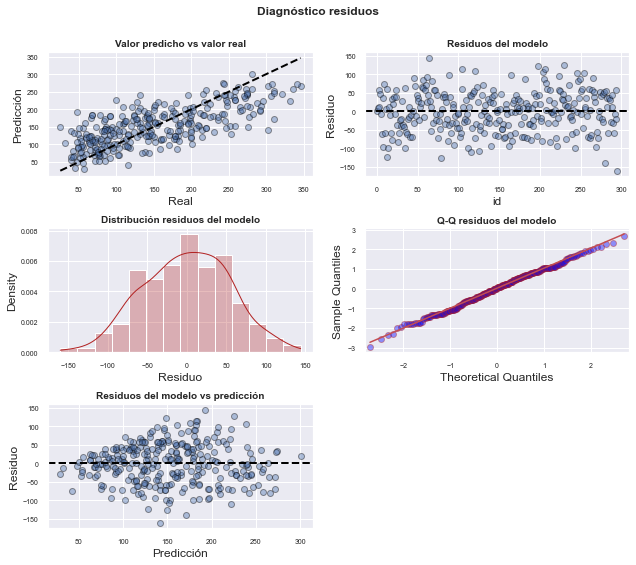

In [132]:
# DIVISION
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# CREAR MODELO Y ENTRENAMIENTO
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

# Intervalos de confianza para los coeficientes del modelo
# ==============================================================================
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
print(intervalos_ci)

# Diagnostico de Errores
# ==============================================================================
y_train_flatten = y_train.values.flatten()
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train_flatten
diagnostic_garbages(y_train_flatten, prediccion_train,residuos_train)

In [133]:
# Otra opción
# División de los datos en train y test
# ==============================================================================
X = datos[['age', 'sex', 'bmi', 'bp', 's1']]
y = datos['target']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y.values.reshape(-1,1),
                                                    train_size   = 0.8,
                                                    random_state = 1234,
                                                    shuffle      = True
                                                    )

In [134]:
# Entrenamos el modelo
# ==============================================================================
lr = LinearRegression()
modelo = lr.fit(X_train,y_train)
y_pred = modelo.predict(X_test)

# Diagnóstico errores (residuos) de las predicciones de entrenamiento
# ==============================================================================

y_train = y_train.flatten()
prediccion_train = modelo.predict(X_train)
residuos_train   = prediccion_train - y_train

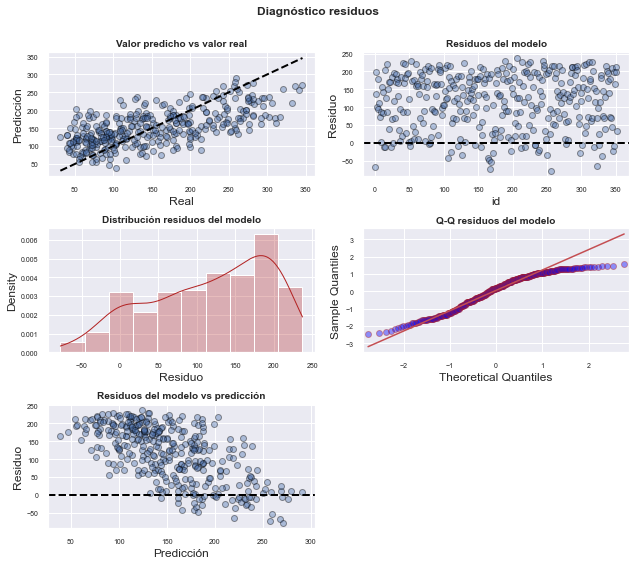

In [135]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         figsize=(9, 8))

axes[0, 0].scatter(y_train, 
                   prediccion_train, 
                   edgecolors = (0, 0, 0), 
                   alpha = 0.4)
axes[0, 0].plot([y_train.min(), 
                 y_train.max()], 
                 [y_train.min(), y_train.max()],
                 'k--', 
                 color = 'black', 
                 lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', 
                     fontsize = 10, 
                     fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), 
                   residuos_train[0],
                   edgecolors=(0, 0, 0), 
                   alpha = 0.4)
axes[0, 1].axhline(y = 0, 
                   linestyle = '--', 
                   color = 'black', 
                   lw=2)
axes[0, 1].set_title('Residuos del modelo', 
                      fontsize = 10, 
                      fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train[0],
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', 
                      fontsize = 10,
                      fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train[0],
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', 
                      fontsize = 10, 
                      fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, 
                   residuos_train[0],
                   edgecolors=(0, 0, 0), 
                   alpha = 0.4)
axes[2, 0].axhline(y = 0, 
                   linestyle = '--', 
                   color = 'black', 
                   lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', 
                      fontsize = 10, 
                      fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', 
            fontsize = 12, 
            fontweight = "bold");

In [136]:
# Evaluamos los resultados

y_pred = modelo.predict(X_test)
lineal_r2 = r2_score(y_test, y_pred)
lineal_comp = pd.DataFrame(list(zip(y_test, y_pred)), columns = ['Actual Values', 'Predicted Values']) 

print('Valor de R2: ' + str(lineal_r2))
print('\nTabla de comparacion: \n\n' + str(lineal_comp))

Valor de R2: 0.31883984639572516

Tabla de comparacion: 

   Actual Values      Predicted Values
0        [109.0]  [105.67793239059459]
1        [283.0]  [165.43953816754538]
2        [101.0]    [74.4509506623898]
3        [158.0]   [73.89006726956933]
4        [201.0]  [138.47927093331796]
5         [48.0]  [207.10289627277365]
6        [100.0]  [152.63386718683094]
7        [103.0]  [173.81661834534245]
8         [71.0]  [103.83217352902474]
9         [85.0]   [174.4000288578529]
10        [78.0]  [108.31318588871137]
11       [270.0]  [243.96792959295777]
12       [175.0]   [236.1662459718082]
13       [141.0]  [184.66696886222886]
14        [60.0]  [143.02624216488613]
15       [150.0]  [116.09327324956945]
16        [68.0]   [153.9269668732756]
17        [59.0]  [154.90164975836527]
18       [310.0]  [228.79694653825754]
19       [170.0]  [134.47472927812623]
20        [63.0]   [179.2797677914242]
21        [25.0]  [150.51523186526856]
22       [136.0]   [185.3517561735526]
23    

# Red neuronal

In [137]:
# Estructura de la red
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 64, activation = tf.nn.relu, input_shape = [X_train.shape[1]]),
    tf.keras.layers.Dense(units = 32, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 1)
    ])

In [138]:
# Definimos el optimizador
optimizador = tf.keras.optimizers.RMSprop(0.001)

# Compilamos el modelo con la funcion de perdida, optimizador y las metricas para evaluar el comportamiento
model.compile(loss = 'mse', 
            optimizer = optimizador,
            metrics = ['mae','mse'])
            
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Entrenamos la red
history = model.fit(X_train, 
                    y_train, 
                    epochs = 750)#, validation_data=(X_test, y_test))

Epoch 1/750
12/12 [==============================] - 1s 3ms/step - loss: 29194.7812 - mae: 152.2048 - mse: 29194.7812
Epoch 2/750
12/12 [==============================] - 0s 2ms/step - loss: 29096.8047 - mae: 151.8846 - mse: 29096.8047
Epoch 3/750
12/12 [==============================] - 0s 3ms/step - loss: 28969.2266 - mae: 151.4586 - mse: 28969.2266
Epoch 4/750
12/12 [==============================] - 0s 3ms/step - loss: 28797.0938 - mae: 150.9051 - mse: 28797.0938
Epoch 5/750
12/12 [==============================] - 0s 2ms/step - loss: 28594.5293 - mae: 150.2326 - mse: 28594.5293
Epoch 6/750
12/12 [==============================] - 0s 3ms/step - loss: 28355.1934 - mae: 149.4289 - mse: 28355.1934
Epoch 7/750
12/12 [==============================] - 0s 2ms/step - loss: 28077.3398 - mae: 148.5062 - mse: 28077.3398
Epoch 8/750
12/12 [==============================] - 0s 2ms/step - loss: 27747.1152 - mae: 147.4013 - mse: 27747.1152
Epoch 9/750
12/12 [==============================] - 0s 

Epoch 71/750
12/12 [==============================] - 0s 2ms/step - loss: 4569.4697 - mae: 58.1918 - mse: 4569.4697
Epoch 72/750
12/12 [==============================] - 0s 3ms/step - loss: 4551.5884 - mae: 57.9527 - mse: 4551.5884
Epoch 73/750
12/12 [==============================] - 0s 2ms/step - loss: 4535.3110 - mae: 57.9932 - mse: 4535.3110
Epoch 74/750
12/12 [==============================] - 0s 3ms/step - loss: 4529.2847 - mae: 57.9808 - mse: 4529.2847
Epoch 75/750
12/12 [==============================] - 0s 3ms/step - loss: 4512.4062 - mae: 57.8191 - mse: 4512.4062
Epoch 76/750
12/12 [==============================] - 0s 3ms/step - loss: 4489.2661 - mae: 57.5090 - mse: 4489.2661
Epoch 77/750
12/12 [==============================] - 0s 2ms/step - loss: 4476.6318 - mae: 57.5226 - mse: 4476.6318
Epoch 78/750
12/12 [==============================] - 0s 3ms/step - loss: 4453.9297 - mae: 57.2243 - mse: 4453.9297
Epoch 79/750
12/12 [==============================] - 0s 3ms/step - loss

12/12 [==============================] - 0s 3ms/step - loss: 3727.5081 - mae: 50.9767 - mse: 3727.5081
Epoch 142/750
12/12 [==============================] - 0s 3ms/step - loss: 3722.4165 - mae: 50.9557 - mse: 3722.4165
Epoch 143/750
12/12 [==============================] - 0s 3ms/step - loss: 3715.4812 - mae: 50.8853 - mse: 3715.4812
Epoch 144/750
12/12 [==============================] - 0s 4ms/step - loss: 3706.3948 - mae: 50.9329 - mse: 3706.3948
Epoch 145/750
12/12 [==============================] - 0s 3ms/step - loss: 3706.7019 - mae: 50.9418 - mse: 3706.7019
Epoch 146/750
12/12 [==============================] - 0s 3ms/step - loss: 3690.7854 - mae: 50.6886 - mse: 3690.7854
Epoch 147/750
12/12 [==============================] - 0s 4ms/step - loss: 3689.7942 - mae: 50.7640 - mse: 3689.7942
Epoch 148/750
12/12 [==============================] - 0s 3ms/step - loss: 3682.6821 - mae: 50.5678 - mse: 3682.6821
Epoch 149/750
12/12 [==============================] - 0s 3ms/step - loss: 368

12/12 [==============================] - 0s 2ms/step - loss: 3543.6580 - mae: 49.2332 - mse: 3543.6580
Epoch 212/750
12/12 [==============================] - 0s 3ms/step - loss: 3543.0037 - mae: 49.4350 - mse: 3543.0037
Epoch 213/750
12/12 [==============================] - 0s 2ms/step - loss: 3548.6519 - mae: 49.3712 - mse: 3548.6519
Epoch 214/750
12/12 [==============================] - 0s 3ms/step - loss: 3544.0525 - mae: 49.2726 - mse: 3544.0525
Epoch 215/750
12/12 [==============================] - 0s 3ms/step - loss: 3544.4175 - mae: 49.3457 - mse: 3544.4175
Epoch 216/750
12/12 [==============================] - 0s 3ms/step - loss: 3543.3005 - mae: 49.4090 - mse: 3543.3005
Epoch 217/750
12/12 [==============================] - 0s 4ms/step - loss: 3550.2710 - mae: 49.2694 - mse: 3550.2710
Epoch 218/750
12/12 [==============================] - 0s 3ms/step - loss: 3551.2061 - mae: 49.2034 - mse: 3551.2061
Epoch 219/750
12/12 [==============================] - 0s 3ms/step - loss: 354

12/12 [==============================] - 0s 3ms/step - loss: 3524.4714 - mae: 48.8870 - mse: 3524.4714
Epoch 282/750
12/12 [==============================] - 0s 1ms/step - loss: 3520.3064 - mae: 49.0259 - mse: 3520.3064
Epoch 283/750
12/12 [==============================] - 0s 3ms/step - loss: 3524.8477 - mae: 49.0640 - mse: 3524.8477
Epoch 284/750
12/12 [==============================] - 0s 3ms/step - loss: 3524.7075 - mae: 49.0574 - mse: 3524.7075
Epoch 285/750
12/12 [==============================] - 0s 3ms/step - loss: 3521.7437 - mae: 49.0168 - mse: 3521.7437
Epoch 286/750
12/12 [==============================] - 0s 3ms/step - loss: 3520.6016 - mae: 48.7409 - mse: 3520.6016
Epoch 287/750
12/12 [==============================] - 0s 2ms/step - loss: 3524.8081 - mae: 49.0763 - mse: 3524.8081
Epoch 288/750
12/12 [==============================] - 0s 3ms/step - loss: 3523.4385 - mae: 49.0618 - mse: 3523.4385
Epoch 289/750
12/12 [==============================] - 0s 2ms/step - loss: 352

12/12 [==============================] - 0s 3ms/step - loss: 3529.1125 - mae: 48.9575 - mse: 3529.1125
Epoch 352/750
12/12 [==============================] - 0s 1ms/step - loss: 3510.6208 - mae: 48.7268 - mse: 3510.6208
Epoch 353/750
12/12 [==============================] - 0s 3ms/step - loss: 3511.9150 - mae: 48.7426 - mse: 3511.9150
Epoch 354/750
12/12 [==============================] - 0s 3ms/step - loss: 3518.8545 - mae: 48.8480 - mse: 3518.8545
Epoch 355/750
12/12 [==============================] - 0s 3ms/step - loss: 3515.3545 - mae: 48.6478 - mse: 3515.3545
Epoch 356/750
12/12 [==============================] - 0s 3ms/step - loss: 3514.5630 - mae: 48.8202 - mse: 3514.5630
Epoch 357/750
12/12 [==============================] - 0s 1ms/step - loss: 3511.6543 - mae: 48.9277 - mse: 3511.6543
Epoch 358/750
12/12 [==============================] - 0s 2ms/step - loss: 3522.4395 - mae: 49.1010 - mse: 3522.4395
Epoch 359/750
12/12 [==============================] - 0s 3ms/step - loss: 351

12/12 [==============================] - 0s 3ms/step - loss: 3512.1274 - mae: 48.9785 - mse: 3512.1274
Epoch 422/750
12/12 [==============================] - 0s 3ms/step - loss: 3510.4575 - mae: 49.0911 - mse: 3510.4575
Epoch 423/750
12/12 [==============================] - 0s 3ms/step - loss: 3511.8687 - mae: 48.8006 - mse: 3511.8687
Epoch 424/750
12/12 [==============================] - 0s 3ms/step - loss: 3508.6626 - mae: 48.9161 - mse: 3508.6626
Epoch 425/750
12/12 [==============================] - 0s 3ms/step - loss: 3505.1892 - mae: 48.6688 - mse: 3505.1892
Epoch 426/750
12/12 [==============================] - 0s 3ms/step - loss: 3507.8616 - mae: 48.4950 - mse: 3507.8616
Epoch 427/750
12/12 [==============================] - 0s 3ms/step - loss: 3508.8972 - mae: 48.6511 - mse: 3508.8972
Epoch 428/750
12/12 [==============================] - 0s 3ms/step - loss: 3503.1990 - mae: 48.7668 - mse: 3503.1990
Epoch 429/750
12/12 [==============================] - 0s 3ms/step - loss: 350

12/12 [==============================] - 0s 3ms/step - loss: 3503.4180 - mae: 48.5357 - mse: 3503.4180
Epoch 492/750
12/12 [==============================] - 0s 3ms/step - loss: 3510.2375 - mae: 48.5015 - mse: 3510.2375
Epoch 493/750
12/12 [==============================] - 0s 2ms/step - loss: 3499.3477 - mae: 48.6726 - mse: 3499.3477
Epoch 494/750
12/12 [==============================] - 0s 3ms/step - loss: 3498.3701 - mae: 48.5770 - mse: 3498.3701
Epoch 495/750
12/12 [==============================] - 0s 3ms/step - loss: 3499.0215 - mae: 48.9371 - mse: 3499.0215
Epoch 496/750
12/12 [==============================] - 0s 4ms/step - loss: 3506.4912 - mae: 48.8343 - mse: 3506.4912
Epoch 497/750
12/12 [==============================] - 0s 3ms/step - loss: 3496.2510 - mae: 48.6355 - mse: 3496.2510
Epoch 498/750
12/12 [==============================] - 0s 2ms/step - loss: 3508.3052 - mae: 48.4868 - mse: 3508.3052
Epoch 499/750
12/12 [==============================] - 0s 2ms/step - loss: 350

12/12 [==============================] - 0s 3ms/step - loss: 3499.5898 - mae: 48.4065 - mse: 3499.5898
Epoch 562/750
12/12 [==============================] - 0s 3ms/step - loss: 3493.5061 - mae: 48.6564 - mse: 3493.5061
Epoch 563/750
12/12 [==============================] - 0s 3ms/step - loss: 3491.6550 - mae: 48.7732 - mse: 3491.6550
Epoch 564/750
12/12 [==============================] - 0s 3ms/step - loss: 3493.1062 - mae: 48.6845 - mse: 3493.1062
Epoch 565/750
12/12 [==============================] - 0s 2ms/step - loss: 3495.3735 - mae: 48.8025 - mse: 3495.3735
Epoch 566/750
12/12 [==============================] - 0s 2ms/step - loss: 3493.4653 - mae: 48.7347 - mse: 3493.4653
Epoch 567/750
12/12 [==============================] - 0s 3ms/step - loss: 3499.9810 - mae: 48.8612 - mse: 3499.9810
Epoch 568/750
12/12 [==============================] - 0s 3ms/step - loss: 3492.7681 - mae: 48.7638 - mse: 3492.7681
Epoch 569/750
12/12 [==============================] - 0s 3ms/step - loss: 349

12/12 [==============================] - 0s 3ms/step - loss: 3487.3569 - mae: 48.7787 - mse: 3487.3569
Epoch 632/750
12/12 [==============================] - 0s 3ms/step - loss: 3496.0132 - mae: 48.5674 - mse: 3496.0132
Epoch 633/750
12/12 [==============================] - 0s 3ms/step - loss: 3489.3091 - mae: 48.3437 - mse: 3489.3091
Epoch 634/750
12/12 [==============================] - 0s 3ms/step - loss: 3492.5574 - mae: 48.3437 - mse: 3492.5574
Epoch 635/750
12/12 [==============================] - 0s 2ms/step - loss: 3481.9604 - mae: 48.5042 - mse: 3481.9604
Epoch 636/750
12/12 [==============================] - 0s 3ms/step - loss: 3483.4417 - mae: 48.6964 - mse: 3483.4417
Epoch 637/750
12/12 [==============================] - 0s 3ms/step - loss: 3482.9604 - mae: 48.4521 - mse: 3482.9604
Epoch 638/750
12/12 [==============================] - 0s 3ms/step - loss: 3485.0723 - mae: 48.5742 - mse: 3485.0723
Epoch 639/750
12/12 [==============================] - 0s 3ms/step - loss: 347

12/12 [==============================] - 0s 2ms/step - loss: 3481.1211 - mae: 48.6037 - mse: 3481.1211
Epoch 702/750
12/12 [==============================] - 0s 3ms/step - loss: 3475.9646 - mae: 48.6306 - mse: 3475.9646
Epoch 703/750
12/12 [==============================] - 0s 3ms/step - loss: 3475.3489 - mae: 48.3844 - mse: 3475.3489
Epoch 704/750
12/12 [==============================] - 0s 2ms/step - loss: 3475.9429 - mae: 48.4038 - mse: 3475.9429
Epoch 705/750
12/12 [==============================] - 0s 2ms/step - loss: 3486.5911 - mae: 48.4095 - mse: 3486.5911
Epoch 706/750
12/12 [==============================] - 0s 2ms/step - loss: 3471.9004 - mae: 48.5558 - mse: 3471.9004
Epoch 707/750
12/12 [==============================] - 0s 4ms/step - loss: 3475.5024 - mae: 48.6614 - mse: 3475.5024
Epoch 708/750
12/12 [==============================] - 0s 3ms/step - loss: 3474.5654 - mae: 48.4327 - mse: 3474.5654
Epoch 709/750
12/12 [==============================] - 0s 3ms/step - loss: 348

In [140]:
# Evaluamos los resultados

hist = pd.DataFrame(history.history)
print('Entrenamiento: \n' + str(hist.tail(3)) + '\n')

y_pred = model.predict(X_test)
red_r2 = r2_score(y_test, y_pred)
red_comp = pd.DataFrame(list(zip(y_test,y_pred)), columns = ['Actual Values', 'Predicted Values'])

print('Valor de R2: ' + str(red_r2))
print('Evaluamos la red: ')
loss, mae, mse = model.evaluate(X_test, y_test)
print('\nTabla de comparacion: \n\n' + str(red_comp))

Entrenamiento: 
            loss        mae          mse
747  3480.013916  48.304745  3480.013916
748  3480.110107  48.274521  3480.110107
749  3474.213867  48.394791  3474.213867

3/3 [==============================] - 0s 0s/step
Valor de R2: 0.3464934595147158
Evaluamos la red: 
3/3 [==============================] - 0s 4ms/step - loss: 3618.5142 - mae: 49.5604 - mse: 3618.5142

Tabla de comparacion: 

   Actual Values Predicted Values
0        [109.0]     [102.027596]
1        [283.0]      [163.38647]
2        [101.0]       [73.74316]
3        [158.0]       [76.41035]
4        [201.0]      [135.36026]
5         [48.0]      [201.74825]
6        [100.0]      [149.63934]
7        [103.0]       [169.8583]
8         [71.0]       [99.29078]
9         [85.0]      [172.19656]
10        [78.0]      [102.71472]
11       [270.0]       [241.3459]
12       [175.0]      [231.59157]
13       [141.0]      [180.36607]
14        [60.0]       [135.7715]
15       [150.0]      [110.93478]
16        [68.